In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd
from scipy.special import erf

In [2]:
# Functional form of each HOD parameter

def M_function(magnitude,A,B,C,D):
    # Function for Mmin and M1
    return (A + 12) + B*(magnitude + 20) + C*(magnitude+20)**2 + D*(magnitude+20)**3 

def M0_function(magnitude, A, B):
    M0s = (A+11) + B*(magnitude+20)
    M0s[M0s <=1.0] = 1.0
    return M0s

def sigma_function(magnitude, A, B, C, D):
    return A + (B-A) / (1.+np.exp((C*(magnitude+20+D))))

def alpha_function(magnitude,A,B,C):
    return A + B ** (-magnitude - 20 + C)

# HODs

def number_centrals(logM, logMmin, sigma):
    return 0.5 * (1 + erf((logM-logMmin)/sigma))

def number_satellites(logM, logM0, logM1, alpha):
    N = ((10**logM-10**logM0)/10**logM1)**alpha
    N[np.isnan(N)] = 0
    return N

In [3]:
# read cosmological parameters of the different simulations
cosmo = np.array(pd.read_csv('data/abacus_cosmologies.csv', skiprows=1))

omega_b    = cosmo[45:,2]
omega_cdm  = cosmo[45:,3]
h          = cosmo[45:,4]
omega_ncdm = cosmo[45:,10]
sigma8_m   = cosmo[45:,13]

Omega_m = (np.array(omega_cdm, dtype='f') + np.array(omega_b, dtype='f') + np.array(omega_ncdm, dtype='f'))/h**2

/tmp/ipykernel_594059/3923751180.py:24: RuntimeWarning: invalid value encountered in power
  N = ((10**logM-10**logM0)/10**logM1)**alpha
/tmp/ipykernel_594059/976478818.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels(np.linspace(0.67, 0.95, 5))
/tmp/ipykernel_594059/976478818.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels(np.linspace(0.23, 0.43, 5))


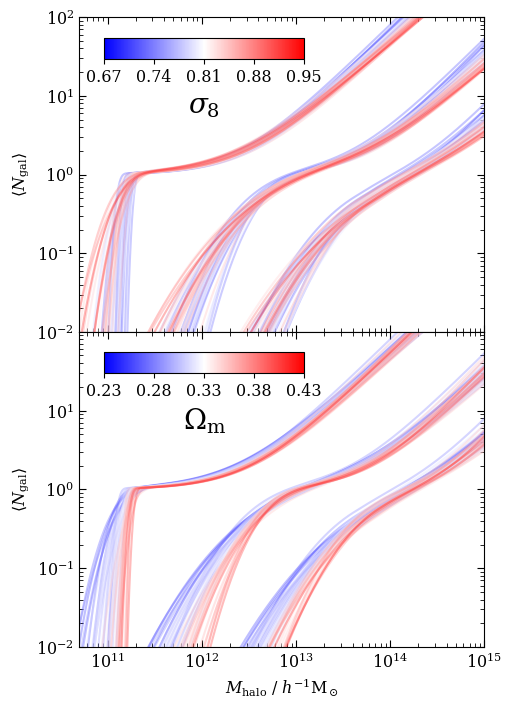

In [5]:
# set font
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# initialize subplots
fig, ax = plt.subplots(2,1, figsize=(5,7))
plt.subplots_adjust(wspace=0, hspace=0, top = 0.98, bottom = 0.08, right = 0.95, left = 0.14)

for i in range(2):
    ax[i].tick_params(direction="in", top=True, right=True, length=5, labelsize=11.5)
    ax[i].tick_params(which="minor", direction="in", top=True, right=True, length=3, labelsize=11.5)
    
mags = np.array([-22, -21, -18])
logM = np.arange(10,16,0.01)

cmap=mpl.colormaps["bwr"]
a=0.3 #set transparency of the curves

# upper panel
idx = np.argsort(sigma8_m)
for c in np.arange(130,182)[idx]:    
    params = np.loadtxt("data/best_fits/AbacusSummit_base_c%03d_ph000_best_params.txt"%c)
    Mmin = M_function(mags, *params[:4])
    sigma = sigma_function(mags, *params[4:8])
    M0 = M0_function(mags, *params[8:10])
    M1 = M_function(mags, *params[10:14])
    alpha = alpha_function(mags, *params[14:])
    
    for i in range(len(mags)):
        Ncen = number_centrals(logM, Mmin[i], sigma[i])
        Nsat = number_satellites(logM, M0[i], M1[i], alpha[i])
        
        s8min = 0.67
        s8max = 0.95
        col = (sigma8_m[c-130] - s8min) / (s8max - s8min)
        
        ax[0].plot(10**logM, Ncen+Nsat*Ncen, c=cmap(col), alpha=a)

# lower panel
idx = np.argsort(Omega_m)
for c in np.arange(130,182)[idx]:
    params = np.loadtxt("data/best_fits/AbacusSummit_base_c%03d_ph000_best_params.txt"%c)
    Mmin = M_function(mags, *params[:4])
    sigma = sigma_function(mags, *params[4:8])
    M0 = M0_function(mags, *params[8:10])
    M1 = M_function(mags, *params[10:14])
    alpha = alpha_function(mags, *params[14:])
    
    for i in range(len(mags)):
        Ncen = number_centrals(logM, Mmin[i], sigma[i])
        Nsat = number_satellites(logM, M0[i], M1[i], alpha[i])
        
        s8min = 0.23
        s8max = 0.43
        col = ( Omega_m[c-130] - s8min) / (s8max - s8min)
        
        ax[1].plot(10**logM, Ncen+Nsat*Ncen, c=cmap(col), alpha=a)

# add colour bars
cbar_ax = fig.add_axes([0.19, 0.92, 0.4, 0.03])
cb = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), cax=cbar_ax, orientation='horizontal')#im, cax=cbar_ax, orientation='horizontal')
cb.set_label(label=r'$\sigma_8$', size=20, labelpad=5, y=4.7, x=0.5, rotation=0)
cb.ax.tick_params(labelsize=11.5)
cb.ax.set_xticklabels(np.linspace(0.67, 0.95, 5)) 

cbar_ax = fig.add_axes([0.19, 0.472, 0.4, 0.03])
cb = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), cax=cbar_ax, orientation='horizontal')#im, cax=cbar_ax, orientation='horizontal')
cb.set_label(label=r'$\Omega_{\rm m}$', size=20, labelpad=5, y=4.7, x=0.5, rotation=0)
cb.ax.tick_params(labelsize=11.5)
cb.ax.set_xticklabels(np.linspace(0.23, 0.43, 5)) 

# set axis limits and labels
for i in range(2):   
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlim(5e10,1e15)
    ax[i].set_ylim(1e-2,1e2)
ax[1].set_ylim(1e-2,99)
ax[0].set_xticklabels([])

ax[1].set_xlabel(r"$M_\mathrm{halo} \ / \ h^{-1}\mathrm{M}_\odot$", fontsize=11.5)
ax[0].set_ylabel(r"$\langle N_\mathrm{gal} \rangle$", fontsize=11.5)
ax[1].set_ylabel(r"$\langle N_\mathrm{gal} \rangle$", fontsize=11.5)

# save the figure as a pdf
plt.savefig("pdf/Figure_8.pdf", dpi=300)